In [1]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path as osp
from tqdm.notebook import tqdm
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    for i in range(len(gpu_devices)):
        tf.config.experimental.set_memory_growth(gpu_devices[i], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


No GPU detected


In [ ]:
path = "/groups/hep/johannbs/common_predictions/predict_files/"
df1 = pd.read_csv(path + 'current_best_predictions.csv')
df2 = pd.read_csv(path + "long_3d.csv")

In [ ]:
df2.columns

In [ ]:
train_cols = ["zenith_pred", "zenith_kap", "energy_log10_pred", "energy_log10_sig", "azimuth_pred", "azimuth_kap"]
df1_train = df1[train_cols]

train_cols = ["zenith_pred", "azimuth_pred", "angle_kap"]
df2_train = df2[train_cols]


Y = df2["zenith"]

In [ ]:
X = pd.concat([df1_train, df2_train], axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
X_zenth =  X_test['zenith_pred']

NameError: name 'train_test_split' is not defined

In [96]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)

In [97]:
X_test = scaler.transform(X_test)

In [185]:
import tensorflow.keras.backend as K
def mse(targets, reco):
    pred     = reco[:, 0]
    kappas   = reco[:, 1]
    return K.mean(K.abs(pred - targets))

def Normal(targets, reco):
    pred     = reco[:, 0]
    kappas   = reco[:, 1]

    log_likelihood  = - (pred - targets) ** 2 * kappas / 2 + K.log(kappas) / 2

    return K.mean(- log_likelihood) 

def mean_zen(targets, reco):
    diffs = K.abs(targets - reco[:, 0])
    u     = K.mean(diffs)
    return u 


In [ ]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input

opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)

hidden_stetes = 32

ind = Input(shape = (9, ))

x   = Dense(4 * hidden_stetes)(ind)
x   = BatchNormalization()(x)
x   = Dropout(0.2)(x)

x   = Dense(4 * hidden_stetes)(x)
x   = BatchNormalization()(x)
x   = Dropout(0.2)(x)

x   = Dense(2 * hidden_stetes)(x)
# x   = BatchNormalization()(x)
x   = Dropout(0.2)(x)


x   = Dense(1 * hidden_stetes)(x)
# x   = BatchNormalization()(x)
x   = Dropout(0.2)(x)


x_pred = Dense(hidden_states // 2)(x)
x_pred = Dense(1)(x_pred)
x_kap  = Dense(hidden_states // 2)(x)
x_kap  = Dense(1)(x_kap) ** 2 + 1e-10

out    = tf.concat([x_pred, x_kap], axis = 1)

model = tf.keras.Model(inputs = ind, outputs = out)
model.compile(optimizer = opt, loss = mse, metrics = [mean_zen])
model.fit(X_train, y_train, epochs = 3, batch_size = 256)
model.compile(optimizer = opt, loss = Normal, metrics = [mean_zen])
model.fit(X_train, y_train, epochs = 10, batch_size = 256)

preds = model.predict(X_test)

In [171]:
preds = model.predict(X_test)

In [172]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 9)]          0                                            
__________________________________________________________________________________________________
dense_209 (Dense)               (None, 128)          1280        input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 128)          512         dense_209[0][0]                  
__________________________________________________________________________________________________
dropout_63 (Dropout)            (None, 128)          0           batch_normalization_76[0][0]     
___________________________________________________________________________________________

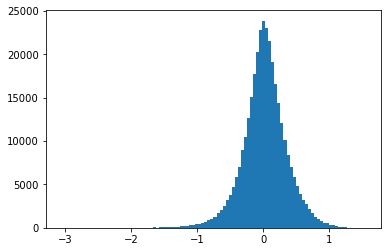

In [173]:
plt.hist(1 / np.sqrt(preds[:, 1]) * (preds[:, 0] - y_test), bins = 100);

In [174]:
preds

array([[1.8331318 , 1.8152056 ],
       [2.0870726 , 2.064126  ],
       [0.72905105, 0.9185489 ],
       ...,
       [2.3189673 , 2.305541  ],
       [2.2495801 , 2.231927  ],
       [2.28991   , 2.27447   ]], dtype=float32)

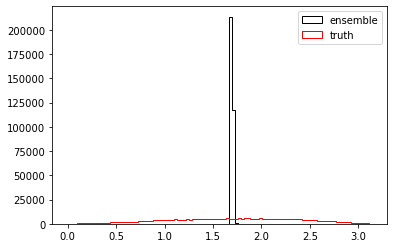

In [149]:
lims  = 0,  np.pi 

plt.hist(zenith_pred, bins = 100, histtype = "step", label = "ensemble", color = "k", range = lims)
plt.hist(y_test, bins = 100, histtype = "step", label = "truth", color = "red", range = lims);
# plt.hist(X_zenth.iloc[:, 0], bins = 100, histtype = "step", label = "2d", range = lims)
# plt.hist(X_zenth.iloc[:, 1], bins = 100, histtype = "step", label = "3d", range = lims);
plt.legend()

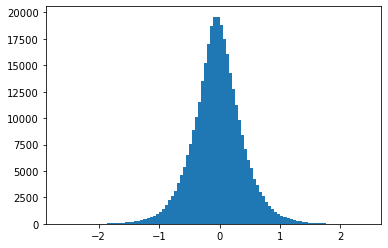

In [112]:
plt.hist(np.array(preds).flatten() - np.array(y_test).flatten(), bins = 100);

In [114]:
np.percentile(abs(np.array(preds).flatten() - np.array(y_test).flatten()), 68)

0.37849990364234637

In [115]:
_ * 180 / np.pi

21.686447024814782

In [119]:
np.percentile(abs(np.array(X_zenth.iloc[:, 0]).flatten() - np.array(y_test).flatten()), 68) * 180 / np.pi

22.04138660716436